In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [5]:
#Loading Data

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


In [7]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


In [8]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [9]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [10]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
#x_preview, y_preview = get_three_classes(test_images, test_labels)

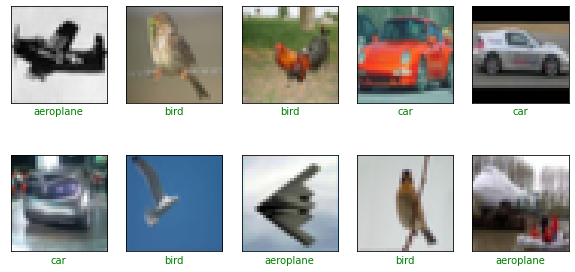

In [11]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [12]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [13]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [14]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [15]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

In [16]:
results = []

## Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

In [17]:
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
model1.add(layers.Dropout(0.3))
model1.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
model1.add(layers.Dropout(0.3))
model1.add(layers.Flatten())
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 512)       14336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [19]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 6s 12ms/step - loss: 1.9470 - accuracy: 0.4784 - val_loss: 1.7472 - val_accuracy: 0.5342
Epoch 2/200
450/450 [==============================] - 5s 12ms/step - loss: 1.4001 - accuracy: 0.6183 - val_loss: 1.3338 - val_accuracy: 0.6360
Epoch 3/200
450/450 [==============================] - 5s 12ms/step - loss: 1.2294 - accuracy: 0.6731 - val_loss: 1.2916 - val_accuracy: 0.6532
Epoch 4/200
450/450 [==============================] - 5s 12ms/step - loss: 1.1579 - accuracy: 0.7065 - val_loss: 1.3544 - val_accuracy: 0.6556
Epoch 5/200
450/450 [==============================] - 5s 12ms/step - loss: 1.1327 - accuracy: 0.7241 - val_loss: 1.2535 - val_accuracy: 0.6892
Epoch 6/200
450/450 [==============================] - 5s 12ms/step - loss: 1.1063 - accuracy: 0.7417 - val_loss: 1.2600 - val_accuracy: 0.6970
Epoch 7/200
450/450 [==============================] - 6s 13ms/step - loss: 1.1095 - accuracy: 0.7519 - val_loss: 1.3679 - val_accuracy:

In [21]:
loss, accuracy = model1.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 1s 3ms/step - loss: 1.3923 - accuracy: 0.7119
test set accuracy:  71.1899995803833 %


In [22]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

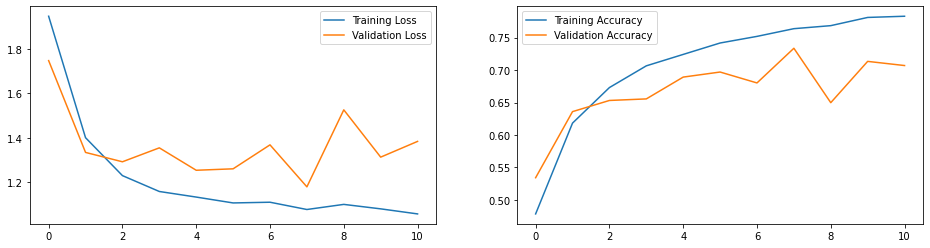

In [23]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [24]:
result_3 = {"Experiemnt": "Experiment 5.3: CNN with 2 Conv/MaxPool Layer w/ reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
            "Val_Loss":val_losses[-1]}
results.append(result_3)

## Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

In [25]:
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
model1.add(layers.Dropout(0.3))
model1.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
model1.add(layers.Dropout(0.3))
model1.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
model1.add(layers.Dropout(0.3))
model1.add(layers.Flatten())
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [26]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 5s 12ms/step - loss: 1.9502 - accuracy: 0.3853 - val_loss: 1.6440 - val_accuracy: 0.4906
Epoch 2/200
450/450 [==============================] - 5s 11ms/step - loss: 1.4373 - accuracy: 0.5372 - val_loss: 1.2535 - val_accuracy: 0.5904
Epoch 3/200
450/450 [==============================] - 5s 12ms/step - loss: 1.2582 - accuracy: 0.5885 - val_loss: 1.1413 - val_accuracy: 0.6206
Epoch 4/200
450/450 [==============================] - 5s 12ms/step - loss: 1.1540 - accuracy: 0.6234 - val_loss: 1.0096 - val_accuracy: 0.6746
Epoch 5/200
450/450 [==============================] - 5s 11ms/step - loss: 1.0803 - accuracy: 0.6462 - val_loss: 1.0009 - val_accuracy: 0.6848
Epoch 6/200
450/450 [==============================] - 5s 12ms/step - loss: 1.0281 - accuracy: 0.6624 - val_loss: 1.0019 - val_accuracy: 0.6762
Epoch 7/200
450/450 [==============================] - 5s 11ms/step - loss: 0.9883 - accuracy: 0.6802 - val_loss: 0.9483 - val_accuracy:

In [28]:
history_dict = history.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)

In [29]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

In [30]:
loss, accuracy = model1.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 1s 3ms/step - loss: 0.8268 - accuracy: 0.7463
test set accuracy:  74.62999820709229 %


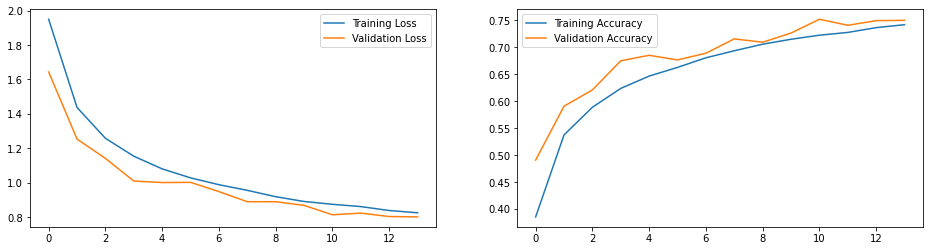

In [31]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [32]:
val_accs[-1]

0.7495999932289124

In [33]:
result_4 = {"Experiemnt": "Experiment 5.4: CNN with 3 Conv/MaxPool Layer w/reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
           "Val_Loss":val_losses[-1]}
results.append(result_4)

In [34]:
results_df = pd.DataFrame(results)

In [35]:
results_df.to_csv("exp5.3&5.4_output.csv", index=False)